In [1]:
%run Latex_macros.ipynb

<IPython.core.display.Latex object>

Macro `_latex_std_` created. To execute, type its name (without quotes).
=== Macro contents: ===
get_ipython().run_line_magic('run', 'Latex_macros.ipynb')
 

In [2]:
# My standard magic !  You will see this in almost all my notebooks.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import training_models_helper as tmh
%aimport training_models_helper

tm = tmh.TrainingModelsHelper()

import svm_helper
%aimport svm_helper
svmh = svm_helper.SVM_Helper()

kn = tmh.KNN_Helper()

import transform_helper
%aimport transform_helper

th = transform_helper.Transformation_Helper()

iph = transform_helper.InfluentialPoints_Helper()

import svm_helper
%aimport svm_helper
svmh = svm_helper.SVM_Helper()

# Transformations

We now spend more time on transforming data.

This may be *the most crucial* step in Classical Machine Learning.
This is the art of Feature Engineering
- transforming features
- adding features
all in the service of finding good predictors

Once we study Deep Learning, we will see how Neural Nets "learn" transformations that are useful.

We have already seen some rudimentary transformations
- polynomial transformation of our "curvy" data set
- "to categorical" for some variables in the Titanic problem
- the sigmoid transformation, used in the target of classification
- price to return for stock prediction

# Why might we need Synthetic Variables

- Compatibility
    - non-numeric to number (one-hot)
    - text to categorical

- To squeeze your problem into the model
    - need to make relationships linear to use a Linear model
    
- Because your model may *demand* it
    - Linear Regression demands
        - homo skedatic residuals
        - normality assumption
    - Some models need all features on similar scale
        - KNN distance metric


- To remove an extraneous relationship
    - "lumpy" data
        - clusters of data groups (e.g., sampled at different times) with differences
        - may violate model assumptions (e.g., independent residuals)
        
- To find the "right" relationship
    - may be a ratio/product between two features, or target and feature
        - area vs (length times width)
        - buying power (Price/GDP)
        

## Caveats on transformations

We perform transformations on the *training data* at fitting time.

The goal is to improve model fit (training) and generalization (test)

The transformations *may change the units and meaning* of features/targets
- price to return

Keep this in mind !


- Transform features of the test data in the same way as training data
    - if you scaled a feature in training, scale it in same way on test data
    - any parameters of the transformation
        - are computed on *training set* only, not test set
        
- Apply inverse transformation of prediction, if desired
    - if you changed units of target in training, you changed units of prediction
    - many transformations are invertable, so you can convert predictions back to original units


`sklearn` provides an easy API with the following methods
- `fit`: set parameters of transformation; fit to training data
- `transform`: apply transformations.  Do this for both train and test data
- `inverse_transform` to convert from transformed data units back to original

# Transformations: introduction

- Many kinds of transformation
- A transformation may be applied for several reason

This makes it hard to provide a clean taxonomy
- I'll classify the type of transformation
based on the example that introduces it.

Be aware however that there may be other reaons for using the transformation.


# Linearity inducing: Making data fit your model: 

We have previously seen how adding a second order polynomial feature transformed our
non-linear "curvy" dataset into one that was linear in model parameters.

Here are a couple of less obvious linearity inducing transformations.

## Between group relationship: constant shift

Suppose we make the same observations at different points in time.

Or we make similar observations in distinct geographies.

The general problem is that we have multiple groups, each differing in some aspect ("lumpy" data)

Can we pool the data across groups ?

Here is an artificial data set (price as a function of area) sampled at two different dates.

We will refer to the data at each date as a "group".

In [4]:
sph = transform_helper.ShiftedPrice_Helper()
series_over_time = sph.gen_data()

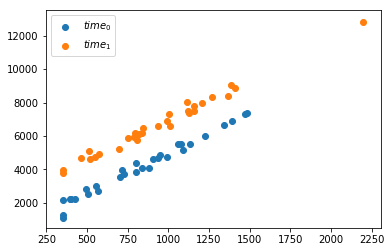

In [5]:
sph.plot_data(series_over_time)

It appears that
- at either time, there is a linear relationship between price and the independent variable
- the slope is the same at both times

So one group of observations looks like the other group with prices offset by a constant.

Perhaps this reflects a tax or rebate that is independent of price.

Do we want to pool this data as is ?

Clearly there is a constant relationship that would be corrupted by doing so.

The solution is to add a new feature: 
- an indicator (dummy, binary variable) that separates the two
groups

Doing so restores the single linear relationship and allows us to pool data that changes with group

Here's what the design matrix $\X''$ looks like when we add the two indicators:

$
  \X'' = \begin{pmatrix}
  \mathbf{const} & \mathbf{Is time}_0 & \mathbf{Is time}_1  & \mathbf{other \; features}\\
  1 &  1 & 0  & \ldots \\ 
  1 &  0 & 1  & \ldots\\ 
   \vdots \\
  \end{pmatrix}
$

- Examples from the first time period look similar to the first row
- Examples from the second time period look similar to the second row
- *Beware of the dummy variable trap* when using a Linear model

Here's an equation that describes the data for each of the two groups:
$$
\begin{array}[lll]\\
y^{\text{time}_0} & = & \Theta^{\text{time}_0}_0 + \Theta_1 * x \\
y^{\text{time}_1} & = & \Theta^{\text{time}_1}_0 + \Theta_1 * x \\
\end{array}
$$

And the regression equation our transformation creates (that also avoids the Dummy Variabe trap)
$$
\begin{array}[lll]\\
y & = & \Theta^{\text{time}_0}_0  + \Theta^{\text{time}'_1} * \text{Is}^{\text{time}_1} + \Theta_1 * x \\
\end{array}
$$

You can see that
- for examples from $\text{time}_0$ the regression equation matches the first equation
- for examples from $\text{time}_1$ the regression equation matches the second equation
    - if $\Theta^{\text{time}'_1} = \Theta^{\text{time}_1}_0 - \Theta^{\text{time}_0}_0$


Note that the two groups don't have to be distinct because of time
- geography
- some other property with a constant impact

Adding the indicator allows the groups to a common $\Theta_1$ (slope) but have
different $\Theta_0$ (intercepts).


## Adding a missing feature as a kind of transformation

Sometimes our models can't fit the data because some key feature is missing.

This was the case for our "curvy" data and Linear model: the polynomial term was missing.

Let's explore a classification problem.  
- The colors denote different classes.
- We won't name the $\x_1, \x_2$ features

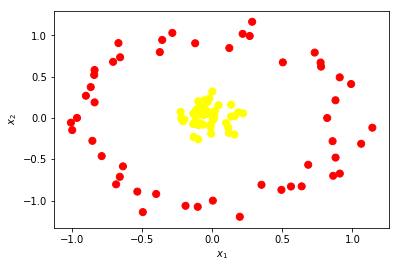

In [6]:
Xc, yc = svmh.make_circles(plot=True)

Visually, we can see that the two classes are separable but can one of our ML algorithms "see" it.

Here's what an SVC (a linear algorithm we will study later) produces

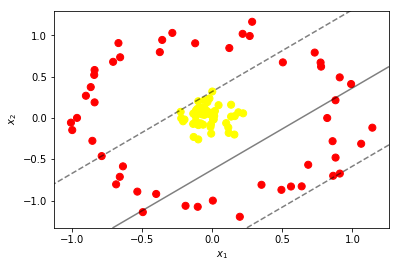

In [7]:
svm_clf = svmh.circles_linear(Xc, yc)

It tries to to fit a linear model (solid line) to separate the data, but is only partially successful:
- predictions for points above the line fall into one class
- predictions for points below the line will fall into the other class

The SVC can isolate *some* of the red points to one side of the line, but not all.

We create a transformation to add a new feature `r`.

Our features are now 3 dimensional; let's look at the plot:

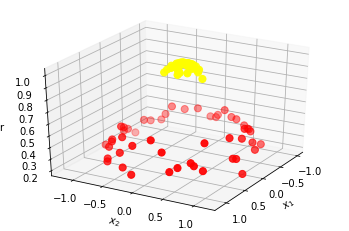

In [8]:
X_w_rbf = svmh.circles_rbf_transform(Xc)
_= svmh.plot_3D(X=X_w_rbf, y=yc )

Magic ! The new feature separates the two classes.
- just like the polynomial feature make the curvy data set linear

The particular transformation is called Radial Basis Function (RBF) Transformation.

Here's the code that created the new feature "r".

In [9]:
r = np.exp( -(Xc ** 2).sum(1) )

Simple.  

Basically, the transformation creates a scalar measure of the distance between
the existing features $\x^\ip$ of example $i$ and the features of a reference point.

Examples that are very
close to the reference point have high values, and the values fall off sharply as the distance increases.

**Note** In the sample code, the reference point is the origin $(0,0)$ 
- but in general the distance would be coded as
 `Xc - x_ref`

From here, any linear classifier should have little difficulty separating the classes.

There is an even simpler transformation we could have used.

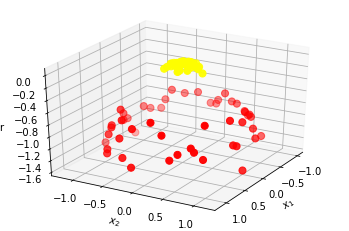

In [10]:
X_w_rad = svmh.circles_radius_transform(Xc)
_= svmh.plot_3D(X=X_w_rad, y=yc )

- The transformation added a feature `r`
    - that measures the L2 distance from $\x^\ip$ to origin $(0,0)$ 
- We could have instead have added a binary indicator feature `r`
    - that is set to `True` if the L2 distance is at most $1$
    
Here's the code to create new feature "r".


**Fundamental point**

- The goal is to have a *logical* justification for the feature
- **not** just because it separates the classes
    - may fail to generalize
    
For example: 
- perhaps $\x_1, \x_2$ measure North/South and East/West distance from city center
- so `r` tells you have far you are from the city center


# Feature scaling

<div class="alert alert-block alert-warning">
<ul>
    <li>We continue to use Linear models to make our points.</li>
    <li>Important to emphasize that some of these points generalize to other models, and some don't</li>
    <li>Linear models are sufficiently useful that we will invest the time even in the cases where the points don't fully generalize</li>
    
 </ul>
 
</div>

Sometimes it is necessary to restrict the *scale* of our data
- features and targets

There are several reasons
- Some models are sensitive to scale
    - features with large differences in scale may affect the model
- Some cost functions are sensitive to scale



## Models sensitive to scale

Consider the following dataset that requires classification into classes indicated by the colors.

The plot at the right shows how a KNN classifier would predict on this dataset.

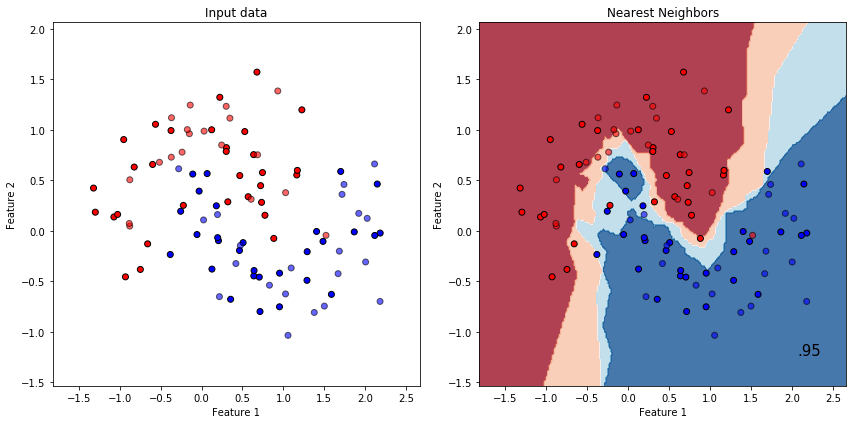

In [11]:
_=  kn. plot_classifiers(scale=False)

The two features are roughly on the same scale (min to max value).

What would happen if the scales were very different for the two features ?

Let's "stretch" the first feature by multiplying it by a factor of 10, leaving the second feature unchanged.

(n.b., accuracy is the number in the lower right of the prediction plot)


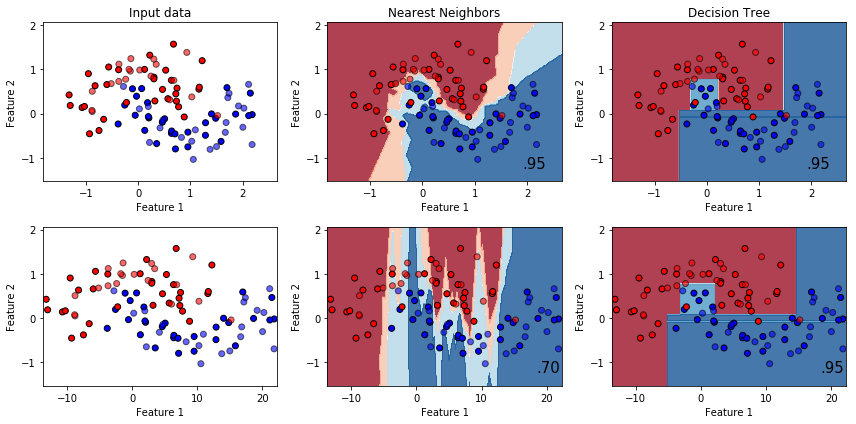

In [12]:
kn = tmh.KNN_Helper()

_ = kn.plot_classifiers(scale=False, num_ds=2)

The first row shows the original dataset; the second the "stretched" data set.

**Note** the horizontal scale of the lower plot is 10 times the upper.
- The plots look the same because the plotting routine keeps the plot sizes the same.

As you can see, the KNN classifier produces drastically different results on the two datasets.

Arguably KNN's predictions on the stretched dataset feel overfit.
- even with overfitting: accuracy drops from 95% to 70%

What is the reason for this ?

If you recall our brief introduction to KNN: 
- the classifier measures the distance between features in a test example and feature in (each) training example
- the distance measure (L2, sum of squared feature-wise differences) is sensitive to scale

$$
\begin{array}[lll]\\
(\x^\ip_1, \x^\ip_2) & \text{training example } i \\
(10 * \x^\ip_1, \x^\ip_2) & \text{stretched training example } i \\
\\
(\x^{(test)}_1, \x^{(test)}_2) & \text{test example} \\
\end{array}
$$

$$
\begin{array}[lll]\\
(\x^{(test)}_1 - \x^\ip_1)^2 & + (\x^{(test)}_2 - \x^\ip_2)^2  & \text{distance from test}\\
(\x^{(test)}_1 -  10 *\x^\ip_1)^2 & + (\x^{(test)}_2 - \x^\ip_2)^2 &\text{stretched distance from test}
\end{array}
$$

Differences in $\x_1$ are much more important than differences in $\x_2$ in the stretched data.

Arguably, the visual plot (which preserved aspect ratio by de-scaling) shows the relationship didn't change.
- just imagine if the units changed from inches to millimeters

In contrast, the Decision Tree classifier (which will be the topic of a subsequent lecture)
is  *insensitive* to the changed scale.
- decision boundaries unchanged
- accuracy unchanged

This motivates Scaling transformations: putting features on similar scales.

## Some scalers

Here a just a few transformations that serve to limit the range of a feature or target.

### MinMax

Covert to $[0,1]$ range.

$$
\hat{\x}^\ip_j = \frac{ \x^\ip_j -  \min{1 \le i \le m}(\x^\ip_j) }{ \min{1 \le i \le m}(\x^\ip_j) - \min{1 \le i \le m}(\x^\ip_j }
$$

New feature is measured in units of "fraction of range".

### Standardize

$$
\hat{x}^\ip_j = { { x^\ip_j - \bar{x_j} } \over { \sigma_{x_j}} }
$$

The new feature has a mean of $0$, i.e., is *zero centered*.

New feature is measured in units of "number of standard deviations".


Let's see how our classifiers perform if we re-scale the data (using standardization) prior to fitting

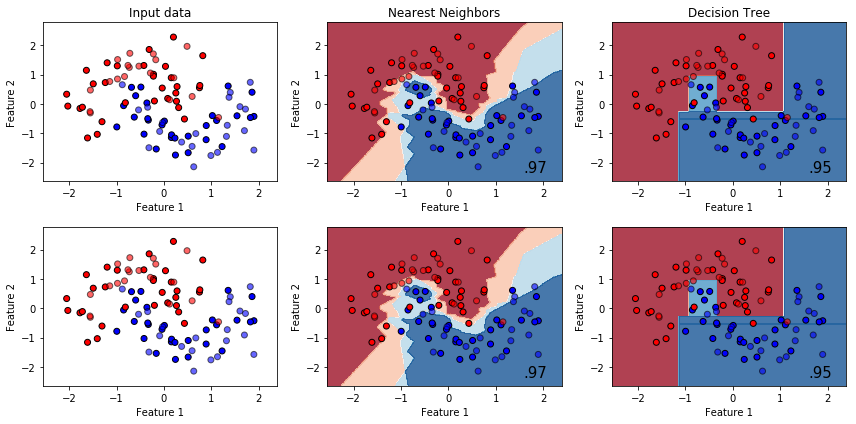

In [13]:
kn = tmh.KNN_Helper()

_ = kn.plot_classifiers(scale=True, num_ds=2)

Standardizing *both* features puts them on similar scale.

The KNN classifier's new behavior
- decision boundaries and accuracy is unaffectd by stretching the data
- accuracy on original (unstretched) data *improves* from 95% to 97%
    - so even original data was not completely insensitive

The Decision Tree is unaffected by scaling.

## Parameters sensitive to scale 

Suppose we have a linear model with a single feature
$$
\y = \Theta_1 * \x_1
$$

If we stretched $\x$ by a factor of 10
$$
\x'_1 = 10 * \x_1
$$

then the same model
$$
\y = \Theta'_1 * \x'_1
$$

will result in
$$
\Theta'_1 = \frac{\Theta_1}{10}
$$


Does that mean the  feature $\x_1$ is now "less important" because $\Theta'_1 < \Theta_1$ ? 

A similar result would be obtained if $\x$ had more than one feature but stretched just one feature.

As we will see 
$$
\Theta_i= \frac{\partial \y}{\partial \x_i}
$$

so that a unit change in feature $\x_i$ results in a change in prediction of magnitude $\Theta_i$.

- By changing the scale of the feature, we may change the scale of its corresponding parameter, which
changes its interpretation.

## Cost functions sensitive to scale: regularization penalty

Recall that we may add penalties to the cost function in order to reduce the magnitude (or number of non-zero)
parameters.

By changing the scale of a feature, we influence its relative importance in the penalty, which
may not be desirable if the scale is unimportant.

### [Ridge Regression](external/PythonDataScienceHandbook/notebooks/05.06-Linear-Regression.ipynb#Ridge-regression-%28$L_2$-Regularization%29)
​
Penalty is: sum (over parameters) of squared paramter value
​
$$
P = \alpha\sum_{n=1}^N \Theta_n^2
$$
​
Also known as $L_2$ regularizer.
​
This tends to push parameters $\theta_n$ towards smaller values.

Stretching a single feature $\x_1$ by a factor of 10 *may* result in a smaller parameter
$$\Theta'_1 \approx \frac{\Theta_1}{10}$$

so the penalty associated with this parameter is decreased by a factor of 100 !

Probably not what we intended when stretching $\x_1$.
- Again: consider changing units from inches to millimeters

#### [Lasso Regression][1]
[1]: external/PythonDataScienceHandbook/notebooks/05.06-Linear-Regression.ipynb#Lasso-regression-($L_1$-regularization)


Penalty is: sum (over parameters) of parameter's absolute value
$$
P = \alpha\sum_{n=1}^N |\Theta_n|
$$

Also know as the $L_1$ regularizer.

Just like the Ridge Regression: 
Stretching a single feature $\x_1$ by a factor of 10 *may* result in a smaller parameter
$$\Theta'_1 \approx \frac{\Theta_1}{10}$$

so the penalty associated with this parameter is decreased by a factor of 10 !


Don't forget our Titanic example
- the default behavior of `sklearn LogisiticRegression` included an L2 penalty
- so you may have this problem and not even be aware of it !

##  Influential points

Some models may be quite sensitive to just a few observations.

This is particularly true for Linear Regression.

Our discussion is somewhat specialized to Linear Regression but you may come to see a similar
phenomenon in other models.

Loosely speaking, an observation is **influential** if 
- the parameter estimate $\Theta$ changes greatly depending on whether the observation is included/excluded

Feature values on the extreme ends of the range have greater potential
for being influential.

This is one argument for constraining the range of the feature (MinMax, Standardization).

The **leverage** of an observation is related to the value of a feature in relation to the mean (across observations) of the feature
- extreme values of the feature have higher leverage

It is not always the case, but high leverage sometimes makes the point influential

[Influence from leverage and distance](http://onlinestatbook.com/2/regression/influential.html)
>An observation's influence is a function of two factors: (1) how much the observation's value on the predictor variable differs from the mean of the predictor variable and (2) the difference between the predicted score for the observation and its actual score. The former factor is called the observation's leverage. The latter factor is called the observation's distance.

Calculation of Leverage (h) of example $i$, feature $j$

[formula](https://learnche.org/pid/least-squares-modelling/outliers-discrepancy-leverage-and-influence-of-the-observations#leverage)

$$ 
\begin{array}{lll}
h^\ip_j & = & { 1 \over n }+ \frac{ (\x^\ip_j - \bar{\x_j})^2}{ \sum_i { (\x^\ip_j - \bar{\x_j})^2} } \\
    & = & \frac{ 1 + \left( \frac{\x^\ip_j - \bar{\x_j}}{\sigma_{\x_j} } \right) ^2}{n}
\end{array}
$$

You can see that the leverage of $\x^\ip_j$ depends on the (standardized) distance of $x^\ip_j$ from the mean (over all $i$) of $\x_i$.

Here's an interactive tool to get a feel for influential points.

It allows you to change the value of a single data point and see how the Linear Regression is affected.

Observe how the slope changes (displayed in the title)
- The `x_l` slider chooses the index of the data point to change
- The `y_l` slider chooses how much the data point changes
 - i.e., will change $\x^\ip$ when `x_l = i`
- 10 data points
  

In [14]:
# Generate some points
(x_ip,y_ip) = iph.gen_data(10)

# Fit a line to the points; get a function to update the fit and the plot
fit_update = iph.plot_init()  


In [15]:
iph.plot_interact(fit_update)

interactive(children=(IntSlider(value=5, description='x_l', max=9), IntSlider(value=0, description='y_l', max=…

How do we handle influential data points in training ?
- scaling may help, by reducing leverage
- drop the example
- Clipping: bound the min/max value of a feature
    - Winsorization

# Feature normalization


## Between group relationship: relative slope change

Similar to our previous example: Between Group Relationship with constant shift.

Here, the slope shifts rather than the level.

To recap:

The general problem is that we have multiple groups, each differing in some aspect ("lumpy" data)

Can we pool the data across groups ?



Here is an artificial data set (price as a function of area) sampled at two different dates.

We will refer to the data at each date as a "group".

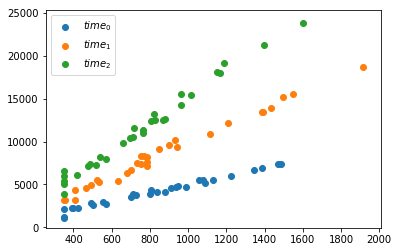

In [16]:
rph = transform_helper.RelativePrice_Helper()
series_over_time = rph.gen_data()

rph.plot_data(series_over_time)

It appears that
- at each time, there is a linear relationship between price and the independent variable
- the slope changes with time

What would happen if we pooled this data unchanged ?

Again, we could try to find a logical reason for the relationship to change over time.

Perhaps it reflects the general change in prices in the economy, i.e., inflation of prices of all goods ?

Let's test this theory by deflating prices by a value that indicates general price levels
relative to time $0$.

In [17]:
# Deflate the prices by an index of general price levels
rel_price = rph.relative_price()

dfs_d = []
for i in range(0, len(series_over_time)):
    df = series_over_time[i].copy()
    df["price"] /= rel_price[i]
  
    dfs_d.append(df)

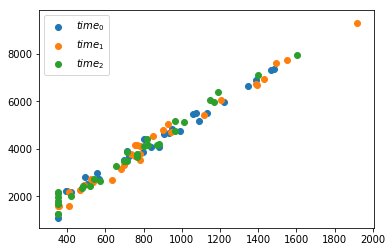

In [18]:
rph.plot_data(dfs_d)

This transformation is a type of normalization: converting everything to the same "units".

Again, the distinction between groups doesn't have to be one of time.

Note that the two groups don't have to be distinct because of time
- different countries
    - linear relationship between area ($\x_1$) and price ($\y$) in *local currency*
    - each group's price converted to USD
    - so group slope is exchange rate !
- inflation affecting price levels
    - convert prices to "constant dollar" prices


Here's an equation that describes the data for each of the first two groups:

$$
\begin{array}[lll]\\
y^{\text{time}_0} & = &  \beta^\text{time}_0  *( \Theta_0 + \Theta_1 * x ) \\
y^{\text{time}_1} & = &  \beta^\text{time}_1  *( \Theta_0 + \Theta_1 * x ) \\
\end{array}
$$

And the regression equation for the transformed data:
$$
\begin{array}[lll]\\
\frac{y^{\text{time}_0}}{\beta^\text{time}_0 } & = &   \Theta_0 + \Theta_1 * x  \\
\frac{y^{\text{time}_1}}{\beta^\text{time}_1 } & = &   \Theta_0 + \Theta_1 * x  \\
\end{array}
$$

You don't have to get too fancy when adjusting price levels
- consider redominating in units of "number of McDonald's burgers" !
- may work across time and currency

As long as all commodity prices change the same, this should work.

# Normality inducing transformations

## Adding missing feature as a normality inducing transformation


The Linear Regression model is
$$
\y = \Theta^T \x + \epsilon
$$

As explained before, Regression produces a conditional probability
$$
\pr{\hat{\y} | \x}
$$

where $\hat{\y}$ and $\epsilon$ are *Normally distributed variables.

Assumptions of the Linear Regression model are violated if
- $\epsilon$ is not Normal
- the individual $\epsilon^\ip$ display a pattern
- the individual $\epsilon^\ip$ have different variances (hetero skedatic)


One reason for failure of these assumptions is a missing feature
- "curvy" data set and Linear model
    - we saw pattern of errors: larger in tails
    - variances increased in tail

Adding a feature (e.g.,second order polynomial term for the curvy data set) can be seen
as a normality inducing transformation.

## Log transformation

We've seen this in our lecture on Logistic Regression
- the probabilites are *not* normally distributed
- the odds are *not* normally distributed
- the *log odds* **is** normally distributed


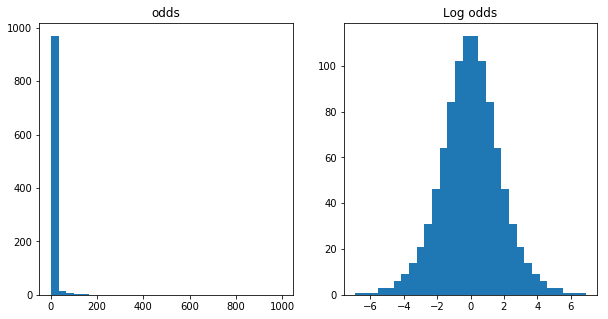

In [19]:
tf = tmh.TransformHelper()
tf.plot_odds()

$$
\begin{array}{llll}
\hat{p} \over {1- \hat{p}} & = &  { 1 \over { 1 + e^{-s} } } \over { 1 -  {1 \over { 1 + e^{-s} } } } \\
& = & { 1 \over { 1 + e^{-s} } } \over { {1 + e^{-s}  -1} \over {1 + e^{-s}} } \\
& = & 1 \over {e^{-s}} \\
& = & e^{s}
\end{array}
$$



So `LogisticRegression` is really just a `LinearRegression` with a transformed target

$$
\textrm{log}( {\hat{p} \over {1- \hat{p}}}) = \Theta^T \cdot x
$$

A log transformation can sometimes impose normality for highly skewed data by reducing the
magnitude of very large points.

# Categorical transformation

We encountered the "to categorical" transformation in the lecture on Classification when
talking about Categorical variables.

The recommended solution was to use One Hot Encoding for Categorical variables.


Remember the difference between Categorical (no order) and Ordinal:
-  "Red, Green, Blue" is categorical (assuming no relationship between colors)
whereas "Small, Medium, Large" is not.

- Representing categorical features with numbers is usually a mistake, because numbers
have ordering and magnitude.

    - We will show why this is mathematically true in the lecture on interpetation.

## OHE and the Dummy variable trap

Unfortunately OHE can lead us into the Dummy Variable Trap when using Linear models.

We now show why this is true.

Suppose categorical variable `Color` has classes $C = \{ \text{Red}, \text{Green}, \text{Blue} \}$.

If One Hot Encoding creates $||C||$ indicator variables, one per class:
- $\mathbf{v}_{Red}, \mathbf{v}_{Green}, \mathbf{v}_{Blue}$

$
\def\min#1{\underset{#1} {\operatorname{min}} }
$

then
for each example $i$:
$$
\sum_{c \in C} { \mathbf{v}^\ip_c } = 1
$$

This means that the indicators in $\mathbf{v}$ are perfectly collinear with the "constant" attribute 1 in each example
representing the intercept term, e.g, $\x_0$.

You can see that $\mathbf{const}$ equals the sum of the indicators for color, for each example:

$
  \X'' = \begin{pmatrix}
  \mathbf{const} & \mathbf{Is Red} & \mathbf{Is Green} & \mathbf{Is Blue}\\
  1 &  1 & 0 & 0 \\ 
  1 &  0 & 0 & 1\\ 
  1 &  0 & 1 & 0 \\ 
   \vdots \\
  \end{pmatrix}
$

When one feature (e.g., the constant) is equal to a linear combination of some other features, this is
called Perfect Multi-collinearity.

Linear Regression has mathematical issues with Perfect Multi-colinearity (or even with Imperfect Multi-collinearity).

This manifests itself as 
- some variables with huge positive parameter values (e.g., $\Theta_{Red}, \Theta_{Blue}$)
- and other variables with huge (offsetting) negative parameter values (e.g., $\Theta_{Green}$).

For now, when using linear models there are several alternatives to avoid the trap
- if you have a categorical variable $v$ with $||C||$ classes

- The vector $\mathbf{v}$ should consist of $||C|| -1$ indicators rather than $||C||$
    - this solution is common enough that several toolkits provide functions to deal with it
        - `sklearn.preprocessing.OneHotEncoder` with argument `drop="first"`
        - Pandas: `pd.get_dummies` with argument `drop_first=True`
- Use a regularizer (e.g., Ridge regression)
- *Don't* include an intercept term
    - But this may cause problems
        - Having an intercept ensures that the errors are mean $0$

- So what does $\mathbf{const}$ mean ?
    - It is associated with parameter $\Theta_{\text{const}}$ (usually $\Theta_0$) which is the intercept of the equation
    
    
- Each of $\mathbf{Is Red}, \mathbf{Is Green}, \mathbf{Is Blue}$ 
    - is associated with a parameter that is the *intercept of its particular class*

- But there are **no** examples in $\X''$ where all of $\mathbf{Is Red}, \mathbf{Is Green}, \mathbf{Is Blue}$ are $0$
    - so $\mathbf{const}$ and its associated parameter $\Theta_{\text{const}}$ are redundant

Let's avoid the Dummy Variable trap via the suggested solution of using only $||C||-1$ indicators.

Here's the design matrix $\X''$ after eliminating one color's indicator ($\mathbf{Is Blue}$).

$\mathbf{const}$ is no longer collinear with $\mathbf{Is Red}, \mathbf{Is Green}$ because of the 
second example (which had color "Blue"):

$
  \X'' = \begin{pmatrix}
  \mathbf{const} & \mathbf{Is Red} & \mathbf{Is Green} \\
  1 &  1 & 0 \\ 
  1 &  0 & 0 \\ 
  1 &  0 & 1 \\ 
   \vdots \\
  \end{pmatrix}
$



Where did $\mathbf{Is Blue}$ go ?
- Eliminating $\mathbf{Is Blue}$ from $ \X''$ results in 
    - the parameter $\Theta_{\text{const}}$ associated with $\mathbf{const}$ is the intercept for class "Blue"
    - the parameter $\Theta_{\text{Is Red}}$ associated with $\mathbf{Is Red}$
        - is the *incremental increase* in intercept for class "Red"
        - increment over $\Theta_{\text{const}}$
    - the parameter $\Theta_{\text{Is Green}}$ associated with $\mathbf{Is Green}$ 
        - is the *incremental increase* in intercept for class "Green"
        - increment over $\Theta_{\text{const}}$

# Cross features

We have already seen a number of examples where adding a simple indicator succeeded in
making our data linearly separable.

Sometimes though, an indicator on a *single* feature won't suffice
- but a synthetic feature that is the *product* of indicators will

A synthetic feature created by combining (multiplying) two or more simple features is called
a *cross term*

Let's revisit our circle classification dataset.

Here we create a cross feature that is `True` if two simpler features hold simultaneously
- $x_1$ indicator: the horizontal offset from the origin $(0,0)$ is "small"
- $x_2$ indicator: the vertical  offset from the origin $(0,0)$ is "small"

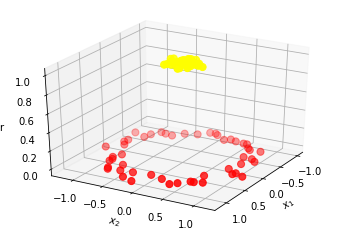

In [20]:
X_w_sq = svmh.circles_square_transform(Xc)
_= svmh.plot_3D(X=X_w_sq, y=yc )

Here's the code to create the new feature "r" as a cross term

We created a single "cross product" indicator $\text{Is}_{\text{in area}}$ as the product of two indicators, one per feature
    
$$
\begin{array}[lll]\\
\text{Is}_{\text{in } x_1 \text{ range}} = (|\x_1| \le 1)\\
\text{Is}_{\text{in } x_2 \text{ range}} = (|\x_2| \le 1)\\
\text{Is}_{\text{in area}} = \text{Is}_{\text{in $x_1$ range}} * \text{Is}_{\text{in $x_2$ range}} \\
\end{array}
$$

Note that only the single $\text{Is}_{\text{in area}}$ indicator is included in the equation
and design matrix $\X''$
- $$\text{Is}_{\text{in } x_1 \text{ range}}, \text{Is}_{\text{in } x_2 \text{ range}}$$ used only to define $\text{Is}_{\text{in area}}$

Cross terms are very tempting but can be abused when over-used.

We can
- create *one indicator per example*
- create a cross term of the example indicator with each paramter in $\Theta$
- this results in a completely separate set of paramters for *each* example
    - we "memorize" the data !

**Create indicator** $I^{(i')}$ **to match example** $i$:
- create indicator $I^{(i')}_j$ to match feature $j$ of example $i$
    - $I^{(i')}_j = \text{True}$ if $\x^{(i')}_j = \x^\ip_j$
- create such an indicator for each feature $1 \le j \le n$
- The n-fold cross feature $I^{(i')} = \prod_{1 \le j \le n}{ I^{(i')}_j}$
    - is `True` when $i' = i$
        - it is the "$\text{Is example } i$" indicator

Here's a picture of the "per example" indicator
$$
\begin{array}[lll]\\
\text{Is}_{\text{example 1}} & = & (\x_1 = \x_1^{(1)}) * (\x_2 = \x_2^{(1)})\\
\text{Is}_{\text{example 2}} & = & (\x_1 = \x_1^{(2)}) * (\x_2 = \x_2^{(2)})\\
\vdots
\end{array}
$$

And here's the design matrix $\X''$ with a separate intercept per example.

$\X''$ has $m$ intercept columns, one for each example,
forming a diagonal of 1's

$
  \X'' = \begin{pmatrix}
  \mathbf{const} & \text{Is}_{\text{example 1}} & \text{Is}_{\text{example 2}} & \text{Is}_{\text{example 3}} & \ldots & \mathbf{other \; features}\\
  1 &  1 & 0  & 0 & \ldots \\ 
  1 &  0 & 1  & 0 & \ldots\\ 
  1 &  0 & 0  & 1 &\ldots\\ 
   \vdots \\
  \end{pmatrix}
$

We can do the same for $\Theta_1, \Theta_2, \ldots, \Theta_n$
resulting in a design matrix $\X''$ with $m * n$ indicators
- one per example per parameter

The associated regression equation has $m * n$ new parameters.

Here's a design matrix $\X''$ with one set of parameters per example:

$
  \X'' = \begin{pmatrix}
  \mathbf{const} & \text{Is}_{\text{example 1}} & (\text{Is}_{\text{example 1}} *\x_1) & (\text{Is}_{\text{example 1}} * \x_2) & \ldots & \text{Is}_{\text{example 2}} & (\text{Is}_{\text{example 2}} *\x_1) & (\text{Is}_{\text{example 2}} * \x_2) & \ldots\\
  1 &  1 & x^{(1)}_1  & x^{(1)}_2 & \ldots & 0 & 0 & 0\\ 
  1 &  0 & 0          & 0         & \ldots  &  1 & x^{(2)}_1  & x^{(2)}_2 \\  
   \vdots \\
  \end{pmatrix}
$

This would give a model with perfect results in the training set but which would likely generalize poorly.

When truly justified a small number of complex cross terms are quite powerful.

# Other transformations

## Centering

Transforming a feature to have mean $0$.

$$
\x^\ip_j = \x^\ip_j - \bar{\x}_j
$$

- low values now become negative
    - more clearly indicates deletrious effect than a low, positive number
    - example: Star Ratings for movies
- some algos (PCA) need centered data


## Bucketing/Binning

- Target may be linear in a feature only in broad ranges of the feature
    - income vs age
        - very young (below working age) all income is identical (0)
        - very old (above retirement) - no job related income
    - Latitude/Longitude
        - small changes matter MUCH less than big changes
        
- Converts numerical feature 
    - into categorical $\mathbf{Is \; bucket \; 1}, \mathbf{Is \; bucket \; 2}, \ldots$
    - ordinal: replace value with center value of bin

Bucket size choices:
- Equal spaced buckets
- Equal quantile buckets

**Lesson** Don't fit a square peg (non-linear response) into a round hole (linear model)

## Outliers

Pull in extreme values to reduce their influence on the fit.

- Clipping, Winsorization

# Feature engineering example: Geron Housing Data
[Geron housing data](external/handson-ml/02_end_to_end_machine_learning_project.ipynb#Get-the-data)
 

## Data: California Housing Prices Data (AG Chapt 2)

In [21]:
housing = tm.load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Each row represents a district

Goal is to predict Median House Value in the district.

- Features
    - total_rooms: number of rooms in the district
    - total_bedrooms: number of bedrooms in the district
    - households; number of households in the district
    - population: number of people in the district
    - median_income: median income of people in the district
    - 
- Target
    - median_house_value: median value of a house in the district

What potential issues pop out ?

Some *raw* features depend on the *size* of the district, so can't compare the same feature across districts.

- total_rooms, total_bedrooms, households, population 

### Feature engineering: Normalization

The first transformation is a kind of normalization
- adjusting a feature for the size of the district
    - divide district aggregate by number of items in the district
- makes the feature comparable across districts of different sizes

In [22]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

By synthesizing ratios:
- rooms/household
- population/household
- bedrooms/room

we have transformed the raw features into processed features that will probably be better predictors

### Feature engineering: Bucketing and Clipping

- Will $1 more of income *really* predict higher housing prices in the district ?
    - create income buckets
        - Disclaimer
            - In the book this is **not** a feature but something used to "stratify" the sample
            - We are taking a bit of artistic license to make a point

In [23]:
print("Median income ranges from {min:.1f} to {max:.1f}".format(min=housing["median_income"].min(), 
                                                                max=housing["median_income"].max()
                                                               ))
# Divide by 1.5 to limit the number of income categories
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)

print("Income buckets")
housing["income_cat"].value_counts()

Median income ranges from 0.5 to 15.0
Income buckets


3.0     7236
2.0     6581
4.0     3639
5.0     1423
1.0      822
6.0      532
7.0      189
8.0      105
9.0       50
11.0      49
10.0      14
Name: income_cat, dtype: int64

Still a lot of buckets.  One theory is that incomes above bucket 5 don't predict housing prices, so clip.

In [24]:
# Label those above 5 as 5
housing["income_cat_clipped"] = housing["income_cat"].where(housing["income_cat"] < 5, 5.0)
print("Income buckets")
housing["income_cat_clipped"].value_counts()

Income buckets


3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: income_cat_clipped, dtype: int64

In [25]:
print("Done")

Done
